# Pricer Option basket
---


#### Libraries set up 
---

In [1]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from numpy.random import default_rng, SeedSequence

sq = SeedSequence()
rng = default_rng(sq)


#### Context

On considère $d \ge 2$ actifs financiers dont la loi à l'instant $T > 0$ est modélisée par une loi log-normale c'est à dire 
$$
    \forall i \in \{1,\dots,d\}, \quad
    S^i_T = S^i_0 \exp\Bigl( \bigl(r-\frac{\sigma_i^2}{2}\bigr) T + \sigma_i \sqrt{T} \tilde G_i \Bigr)
$$
où le vecteur $(\tilde G_1,\dots, \tilde G_d)$ est gaussien centré de matrice de covariance $\Sigma$ et les constantes $r > 0$, $\sigma_i > 0$ sont fixées. Il s'agit d'actifs financiers $(S^i_t)_{t \in [0,T]}$, $1 \le i \le d$, modélisés par un processus de Black-Scholes multidimensionnel. On introduit la matrice $L$ triangulaire inférieure obtenue par la décomposition de Cholesky de la matrice $\Sigma = L L^\top$. 

A l'aide de cette matrice $L$, on définit la fonction $\Phi:\mathbf{R}^d \to \mathbf{R}^d$ telle que 
$$
    (S^1_T, \dots, S^d_T) = \Phi(G_1, \dots, G_d) \quad \text{ou encore} \quad S^i_T = \Phi_i(G_1, \dots, G_d)
$$
où $(G_1, \dots, G_d) \sim \mathcal{N}(0, I_d)$ (l'égalité précédente est à considérer en loi).

In [2]:
d = 40
T = 1
r = 0.1
S0 = np.full(d, 100)
#sigma = np.arange(1,d+1)/(2*d)
sigma = np.full(d, 0.3)
rho = 0.3
correl = np.full((d,d), rho) + (1-rho)*np.eye(d) # ou np.diag(np.full(d, 1-rho))
K = 100

In [14]:
params = {
    "S0": S0[:, np.newaxis],
    "sigma": sigma[:, np.newaxis],
    "mu": r-0.5*sigma[:, np.newaxis]**2,
    "sq_correl": np.linalg.cholesky(correl),  # c'est la matrice L tq L L^T = \Sigma
    "maturity": T,
    "strike": K
}

In [10]:
def phi(indep_Gn, S0, mu, sigma, sq_correl, maturity, strike):
    ST = S0 * np.exp(mu * maturity + sigma * np.sqrt(maturity) * sq_correl @ indep_Gn)
    return np.maximum(np.mean(ST, axis=0)-strike, 0)

## Approximation Monte Carlo
---

On s'intéresse au prix d'une option européenne (aussi appelé produit dérivé européen) sur le panier de ces $d$ actifs financiers, c'est à dire qu'on veut calculer 
$$
    \mathbf{E} \bigl[ X \bigr] %\quad \text{avec} \quad g(x) = (x-K)_+ \quad \text{ou} \quad g(x) = (K-x)_+ 
    \quad \text{avec} \quad 
    X = \biggl(\frac{1}{d} \sum_{i=1}^d S^i_T  - K\biggr)_+
$$

In [11]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = sps.norm.ppf(1 - alpha/2)  # fonction quantile 
    ci_size = quantile * np.sqrt(var / sample.size)
    return (mean, var, mean - ci_size, mean + ci_size)

In [12]:
n = int(1e5)
Gn = rng.standard_normal((d, n)) # ici on a n scénarios possibles 

In [13]:
Gn

array([[ 1.35661922, -0.00483474,  0.41542032, ...,  0.4485371 ,
         0.39349825,  0.5839107 ],
       [-0.80180087,  0.37646225,  1.91907942, ...,  0.75691574,
        -0.35840467,  0.82403803],
       [-0.07374601, -0.02886303, -0.8571943 , ...,  0.52175238,
        -0.48205174, -0.84666063],
       ...,
       [-1.14260755, -1.07150485,  0.71279785, ...,  1.03702758,
        -0.50838892, -2.79650834],
       [ 2.05540091, -1.92704833,  0.11324247, ...,  0.11879079,
         0.35972761,  0.3812108 ],
       [-1.43919403,  1.77235905, -0.44631748, ...,  0.56447271,
        -0.62969451, -0.15452338]])

In [15]:
sample = phi(Gn,**params)
monte_carlo(sample)

(13.557911462244478,
 233.28467219014496,
 13.463246079885478,
 13.652576844603479)

On veut calculer le prix pour différentes valeurs du strike donc on enlève le champ `strike` du dictionnaire `param` et on fera varier ce paramètre.

In [16]:
Ks = [80, 90, 100, 110, 120]
del params["strike"]

In [17]:
result = [monte_carlo(phi(Gn, strike=K, **params)) for K in Ks]
result_df = pd.DataFrame(result, 
                         columns=['Mean', 'Var', 'Lower', 'Upper'], index=Ks)
result_df

,Mean,Var,Lower,Upper
80,30.686955,341.955004,30.572342,30.801567
90,21.432957,304.678870,21.324772,21.541143
100,13.557911,233.284672,13.463246,13.652577
110,7.694649,148.995320,7.618994,7.770303
120,3.918453,79.929774,3.863042,3.973865


## Méthodes de Réduction de Variance

## 1. Variables antithétiques

Sur le même modèle que précédemment, on code une fonction `phi_antith` qui évalue 
$$
    \frac{1}{2} \bigl( \Phi(G_1, \dots, G_d) + \Phi(-G_1, \dots, -G_d) \bigr)
$$
et qu'on va ensuite  utiliser pour implémenter la méthode de Monte Carlo avec réduction de variance par variables antithétiques.


In [18]:
def phi_antith(indep_Gn, **params):
    return 0.5 * (phi(indep_Gn, **params) + phi(-indep_Gn, **params))

In [19]:
sample = phi_antith(Gn, strike=100, **params)
monte_carlo(sample)

(13.553859482335218, 35.74831894503519, 13.516802000616085, 13.590916964054351)

In [20]:
Ks = [80, 90, 100, 110, 120]
result_antith = [monte_carlo(phi_antith(Gn, strike=K, **params)) for K in Ks]
result_antith_df = pd.DataFrame(result_antith, 
                                columns=['Mean', 'Var', 'Lower', 'Upper'], index=Ks)
result_antith_df

,Mean,Var,Lower,Upper
80,30.682161,9.198173,30.663363,30.700958
90,21.427281,19.042258,21.400235,21.454327
100,13.553859,35.748319,13.516802,13.590917
110,7.696622,45.076825,7.655009,7.738235
120,3.924981,32.406083,3.889698,3.960263


In [21]:
ratio_var = pd.DataFrame({
    "method": "Antithetic",
    "strike": Ks, 
    "ratio": result_df['Var'] / result_antith_df['Var'], 
})
ratio_var

,method,strike,ratio
80,Antithetic,80,37.176406
90,Antithetic,90,16.000144
100,Antithetic,100,6.525752
110,Antithetic,110,3.305364
120,Antithetic,120,2.466505


<Axes: xlabel='strike', ylabel='ratio'>

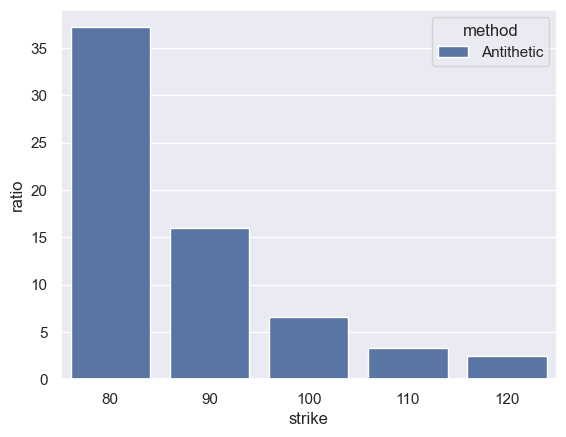

In [22]:
sns.barplot(data=ratio_var, x="strike", y="ratio", hue="method")

## 2. Variable de contrôle

On rappelle que le prix d'un Call dans un modèle de Black-Scholes en dimension 1, le prix est donnée par une formule fermée. Pour une option Basket (en dimension $d \ge 2$) on approche le prix par Monte Carlo mais on peut utiliser des approximations pour trouver un produit unidimensionnel proche du produit Basket. Ces approximations servent de variables de contrôles: **on ne rajoute pas une erreur, on retire de la variance**... 


In [23]:
def d1(spot, t, r, sigma, strike):
    return (np.log(spot / strike) + t * (r + 0.5*sigma**2)) / (sigma * np.sqrt(t))

In [24]:
def d2(spot, t, r, sigma, strike):
    return d1(spot, t, r, sigma, strike) - sigma * np.sqrt(t)

In [25]:
def price_call_BS(spot, t, r, sigma, strike):
    d1_ = d1(spot, t, r, sigma, strike)
    d2_ = d2(spot, t, r, sigma, strike)
    return spot * sps.norm.cdf(d1_) - strike * np.exp(-r * t) * sps.norm.cdf(d2_)

On rappelle que, en posant $\mu_i = r - \frac{1}{2}\sigma_i^2$,
$$
    X = \biggl(\frac{1}{d} \sum_{i=1}^d S^i_0 e^{\mu_i T + \sigma_i \sqrt{T} \tilde G_i}  - K\biggr)_+
$$
et en introduisant $a^i_0 = \frac{S^i_0}{\sum_{j=1}^d S^j_0}$ (t.q. $\sum a^i_0 = 1$) et $\bar S_0 = \frac{1}{d} \sum_{i=1}^d S^i_0$ on a 
$$
    X = \biggl(\bar S_0 \sum_{i=1}^d a^i_0 e^{\mu_i T + \sigma_i \sqrt{T} \tilde G_i}  - K\biggr)_+.
$$
La variable de contrôle proposée est obtenue en échangeant l'exponentielle et la moyenne pondérée par les poids $\big(a^i_0\big)_{i=1,\dots,d}$:
$$
    Y = \bigl(\bar S_0 e^Z  - K\bigr)_+
    \quad \text{avec} \quad 
    Z = \sum_{i=1}^d a^i_0 \big(\mu_i T + \sigma_i \sqrt{T} \tilde G_i\big) 
$$
La variable aléatoire $Z$ suit une loi gaussienne $Z \sim \mathcal{N}(m T, s^2 T)$ avec
$$
    m = \sum_{i=1}^d a^i_0 \mu_i
    \quad \text{et} \quad
    s^2 = \sum_{i=1}^d \Big( \sum_{j=1}^d a^i_0 \sigma_i L_{ij} \Big)^2. 
$$
Ainsi l'espérance de la variable de contrôle $Y$ est connue par la formule de Black-Scholes, car elle correspond au prix d'un call de strike $K$ d'un actif Black-Scholes de dimension 1, de valeur initiale $\bar S_0$, de taux $\rho = m+\frac{1}{2} s^2$ et de volatilité $s$ (à un facteur d'actualisation près... attention à ça). On a donc 
$$
    e^{-\rho T} \mathbf{E} \big[ Y \big] = P_{\text{BS}}\big(\bar S_0, \rho, s, T, K\big) 
$$

On vérifie d'abord les formules: la vraie espérance de $Y$ calculée par formule fermée doit être dans l'intervale de confiance d'un estimateur Monte Carlo basé sur un grand échantillon de $(Y_1,\dots,Y_n)$.

In [27]:
barS0 = params["S0"].mean()
a = params["S0"] / params["S0"].sum()
m = (a * params["mu"]).sum()
s2 = (((a * params["sigma"]).T @ params["sq_correl"])**2).sum()
rho = m + 0.5*s2

In [28]:
# calcul par formule fermée
Y_mean = np.exp(rho*T) * price_call_BS(barS0, T, rho, np.sqrt(s2), strike=K)
print("True value:", Y_mean)

True value: 11.140982930779245


In [29]:
# calcul par Monte Carlo
Z = np.sum(a * (m*T + params["sigma"]*np.sqrt(T)*params["sq_correl"] @ Gn), axis = 0)
Y = np.maximum(S0.mean() * np.exp(Z) - K, 0) 
monte_carlo(Y)

(11.147472359836774, 194.33850825106563, 11.061069618171848, 11.2338751015017)

On regroupe tout dans une fonction $\Psi$ dont l'appel est similaire à $\Phi$ et qui renvoie des réalisations de $Y - \mathbf{E}[Y]$. Il est souvent plus commode d'utiliser des variables de contrôle centrées.

In [30]:
def psi(indep_Gn, S0, mu, sigma, sq_correl, maturity, strike):
    weight = S0 / S0.sum()
    m = (weight * mu).sum()
    s2 = (((weight * sigma).T @ sq_correl)**2).sum()
    rho = m + 0.5*s2

    Z = np.sum(weight * (m*maturity + sigma*np.sqrt(maturity)*sq_correl @ indep_Gn), axis = 0)
    Y = np.maximum(S0.mean() * np.exp(Z) - strike, 0) 
    Y_mean = np.exp(rho*T) * price_call_BS(S0.mean(), maturity, rho, np.sqrt(s2), strike=strike) 
    return Y - Y_mean

In [31]:
# exemple d'un appel de Monte Carlo avec variable de contôle $Y = \Psi(G_1,\dots, G_n)$
sample = phi(Gn, **params, strike=100) - psi(Gn, **params, strike=100)
monte_carlo(sample)

(13.551422033186949,
 3.4586614501445783,
 13.539895409424783,
 13.562948656949114)

In [32]:
Ks = [80, 90, 100, 110, 120]
sample = lambda K: phi(Gn, strike=K, **params) - psi(Gn, strike=K, **params) 
result_cv = [monte_carlo(sample(K)) for K in Ks]
result_cv_df = pd.DataFrame(result_cv, 
                            columns=['Mean', 'Var', 'Lower', 'Upper'], index=Ks)
result_cv_df

,Mean,Var,Lower,Upper
80,30.684226,1.313826,30.677122,30.691330
90,21.429241,2.254147,21.419935,21.438546
100,13.551422,3.458661,13.539895,13.562949
110,7.691453,3.928923,7.679168,7.703739
120,3.928298,3.301745,3.917036,3.939561


In [33]:
def mk_ratio_df(method, ratio): 
    return pd.DataFrame({
        "method": method,
        "strike": Ks, 
        "ratio": ratio, 
    }, index=None)

In [34]:
ratio_var = pd.concat([
    mk_ratio_df("Antithetic", result_df['Var'] / result_antith_df['Var']),
    mk_ratio_df("Control Variate", result_df['Var'] / result_cv_df['Var']),
], ignore_index=True)
ratio_var

,method,strike,ratio
0,Antithetic,80,37.176406
1,Antithetic,90,16.000144
2,Antithetic,100,6.525752
3,Antithetic,110,3.305364
4,Antithetic,120,2.466505
5,Control Variate,80,260.274257
6,Control Variate,90,135.163733
7,Control Variate,100,67.449409
8,Control Variate,110,37.922685
9,Control Variate,120,24.208342


<Axes: xlabel='strike', ylabel='ratio'>

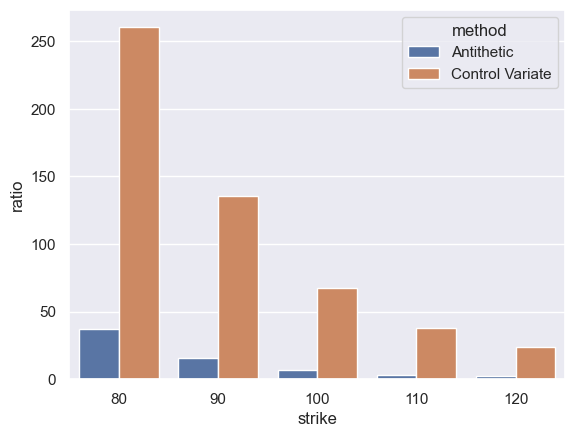

In [35]:
sns.barplot(data=ratio_var, x="strike", y="ratio", hue="method")

### Variable de contrôle optimale 

Si $Y$ est une variable de contrôle 

In [36]:
Ks = [80, 90, 100, 110, 120]

def sample(K):
    Xn = phi(Gn, **params, strike=K)
    Yn = psi(Gn, **params, strike=K)
    lambd = (Xn*Yn).mean() / (Yn*Yn).mean()
    return Xn - lambd * Yn
result_cv2 = [monte_carlo(sample(K)) for K in Ks]
result_cv2_df = pd.DataFrame(result_cv2, 
                            columns=['Mean', 'Var', 'Lower', 'Upper'], index=Ks)
result_cv2_df

,Mean,Var,Lower,Upper
80,30.684116,0.811729,30.678532,30.689701
90,21.429018,1.292989,21.421970,21.436065
100,13.550827,1.838638,13.542422,13.559231
110,7.691036,1.969847,7.682337,7.699735
120,3.929978,1.627964,3.922070,3.937886


In [37]:
ratio_var = pd.concat([
    mk_ratio_df("Antithetic", result_df['Var'] / result_antith_df['Var']),
    mk_ratio_df("Control Variate", result_df['Var'] / result_cv_df['Var']),
    mk_ratio_df("Control Variate adapt", result_df['Var'] / result_cv2_df['Var']),
], ignore_index=True)
ratio_var

,method,strike,ratio
0,Antithetic,80,37.176406
1,Antithetic,90,16.000144
2,Antithetic,100,6.525752
3,Antithetic,110,3.305364
4,Antithetic,120,2.466505
5,Control Variate,80,260.274257
6,Control Variate,90,135.163733
7,Control Variate,100,67.449409
8,Control Variate,110,37.922685
9,Control Variate,120,24.208342


<Axes: xlabel='strike', ylabel='ratio'>

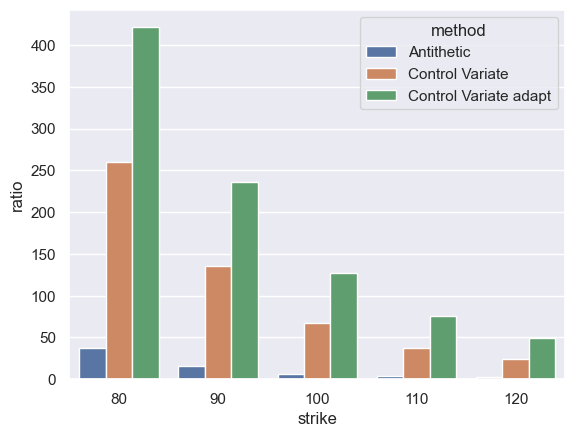

In [38]:
sns.barplot(data=ratio_var, x="strike", y="ratio", hue="method")

## Combinaison des 2 méthodes précédents

In [39]:
Ks = [80, 90, 100, 110, 120]
def sample(K):
    Xn = phi(Gn, **params, strike=K)
    Yn = psi(Gn, **params, strike=K)
    lambd = (Xn*Yn).mean() / (Yn*Yn).mean()
    return 0.5*((Xn - lambd * Yn) \
                + (phi(-Gn, strike=K, **params) - lambd * psi(-Gn, strike=K, **params)))
result_acv = [monte_carlo(sample(K)) for K in Ks]
result_acv_df = pd.DataFrame(result_acv, 
                            columns=['Mean', 'Var', 'Lower', 'Upper'], index=Ks)
result_acv_df

,Mean,Var,Lower,Upper
80,30.685608,0.690063,30.680459,30.690757
90,21.430602,1.028100,21.424317,21.436886
100,13.550893,1.293445,13.543844,13.557942
110,7.692724,0.564475,7.688067,7.697380
120,3.929477,0.661125,3.924437,3.934516


<Axes: xlabel='strike', ylabel='ratio'>

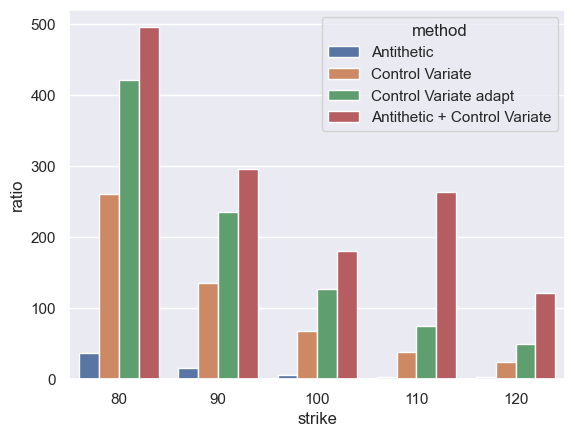

In [40]:
ratio_var = pd.concat([
    mk_ratio_df("Antithetic", result_df['Var'] / result_antith_df['Var']),
    mk_ratio_df("Control Variate", result_df['Var'] / result_cv_df['Var']),
    mk_ratio_df("Control Variate adapt", result_df['Var'] / result_cv2_df['Var']),
    mk_ratio_df("Antithetic + Control Variate", result_df['Var'] / result_acv_df['Var']),
], ignore_index=True)
sns.barplot(data=ratio_var, x="strike", y="ratio", hue="method")

## Etude numérique

Comme tout notre code fonctionne (ou semble fonctionner) pour un jeu de paramètres, commençons maintenant  à faire une vraie étude numérique en faisant varier les paramètres. 

Par exemple nous allons   relancer le notebook avec une autre corrélation. 
- Que donnent les ratios de variance avec $\rho = 0$ ? $\rho = 0.5$ ? Comment interpréter ces résultats ?
- De même, si on ne prend pas des volatilités $\sigma_i$ toutes identiques ? 
- Dépendance en la dimension $d$ ? 

Pour répondre à ces questions, on reprend le code du notebook et on code une fonction qui renvoie un `DataFrame` contenant tous les résultats pour chaque valeur de paramètre: **à faire**.

###  1. Changement de corrélation

In [49]:

# Function to run the simulation with different parameters
def run_simulation(d, rho, sigma_values, T=1, r=0.1, S0_value=100, K=100, n=int(1e5)):
    S0 = np.full(d, S0_value)
    sigma = sigma_values if isinstance(sigma_values, np.ndarray) else np.full(d, sigma_values)
    correl = np.full((d,d), rho) + (1-rho)*np.eye(d)
    params = {
        "S0": S0[:, np.newaxis],
        "sigma": sigma[:, np.newaxis],
        "mu": r - 0.5 * sigma[:, np.newaxis]**2,
        "sq_correl": np.linalg.cholesky(correl),
        "maturity": T,
        "strike": K
    }
    
    # Generate normal random variables
    Gn = rng.standard_normal((d, n))
    
    # Monte Carlo sampling
    sample = phi(Gn, **params)
    result = monte_carlo(sample)
    
    # Antithetic Sampling
    sample_antith = phi_antith(Gn, **params)
    result_antith = monte_carlo(sample_antith)
    
    # Control Variate
    sample_cv = phi(Gn, **params) - psi(Gn, **params)
    result_cv = monte_carlo(sample_cv)
    
    return result, result_antith, result_cv




In [50]:
# Function to collect results for various parameters
def collect_results(d_values, rho_values, sigma_values):
    results = []
    for d in d_values:
        for rho in rho_values:
            for sigma in sigma_values:
                res, res_antith, res_cv = run_simulation(d, rho, sigma)
                results.append({
                    "d": d,
                    "rho": rho,
                    "sigma": sigma,
                    "MC_Mean": res[0],
                    "MC_Var": res[1],
                    "Antithetic_Mean": res_antith[0],
                    "Antithetic_Var": res_antith[1],
                    "CV_Mean": res_cv[0],
                    "CV_Var": res_cv[1]
                })
    return pd.DataFrame(results)


In [62]:
# Example usage:
#d_values = [10, 20, 40,50,60,120,1000]
rho_values = [0, 0.3, 0.5]
#sigma_values = [0.2, 0.3, 0.4]

df_results = collect_results(d_values=[10], rho_values=rho_values, sigma_values=[0.2])

# Display results
df_results


,d,rho,sigma,MC_Mean,MC_Var,Antithetic_Mean,Antithetic_Var,CV_Mean,CV_Var
0,10,0.0,0.2,10.672046,45.384651,10.685738,1.589025,10.685496,1.112276
1,10,0.3,0.2,11.965477,132.967121,11.999980,12.919483,11.994623,0.746302
2,10,0.5,0.2,12.873269,186.941868,12.849768,23.989378,12.844621,0.421434


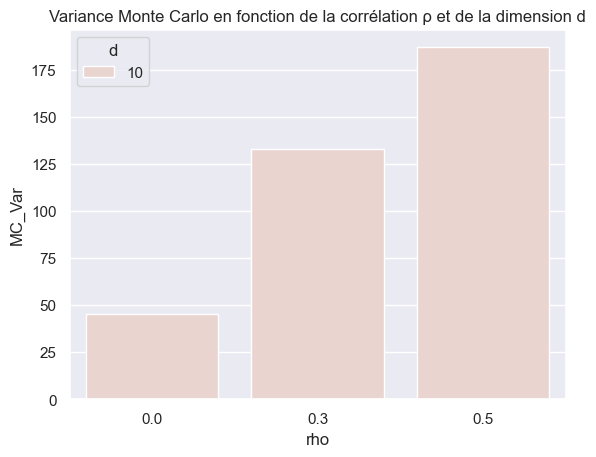

In [63]:
sns.barplot(data=df_results, x="rho", y="MC_Var", hue="d")
plt.title('Variance Monte Carlo en fonction de la corrélation ρ et de la dimension d')
plt.show()



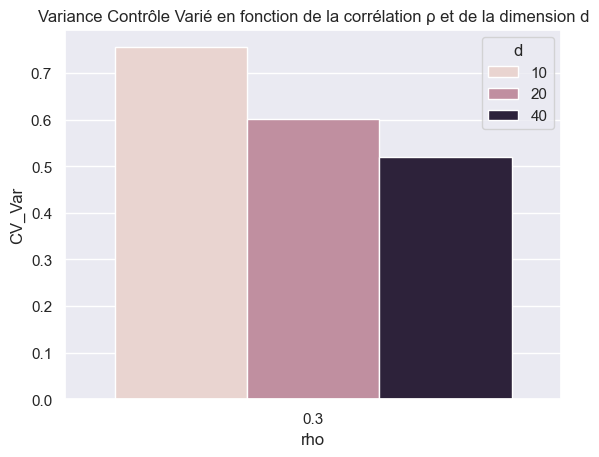

In [55]:
sns.barplot(data=df_results, x="rho", y="CV_Var", hue="d")
plt.title('Variance Contrôle Varié en fonction de la corrélation ρ et de la dimension d')
plt.show()


In [41]:
class basket_black_scholes:
    def __init__(self, S0, r, sigma, sq_correl, maturity, strike):
        # initialisation de la propriété S0 
        self.S0 = S0
        # initialisation des autres arguments comme des attributs (sans vérification)
        self.r, self.sigma, self.sq_correl = r, sigma, sq_correl
        self.maturity, self.strike = maturity, strike
    
    @property
    def S0(self):
        return self._S0
    
    @S0.setter
    def S0(self, value):
        if value.any() <= 0:
            raise ValueError('All elements of S0 must be positive. ')
        if len(value.shape) == 2:
            self.dim, c = value.shape 
            if c != 1: 
                raise ValueError('Must be a column vector of shape (d, 1)')
            self._S0 = value
            return 
        if len(value.shape) != 2:
            raise ValueError('Must be a column vector of shape (d, 1)')
        self._S0 = value
    
    def __repr__(self):
        return repr(f"Basket product of strike {self.strike} and maturity {self.maturity} in the BS model.")
        
    def __generate__(self, indep_Gn):
        mu_T = (self.r - 0.5*self.sigma**2) * self.maturity
        sigrho_sqT = self.sigma * np.sqrt(self.maturity) * self.sq_correl
        ST = self.S0 * np.exp(mu_T + sigrho_sqT @ indep_Gn)
        return ST
        
    def call(self, indep_Gn):
        ST = self.__generate__(indep_Gn)
        return np.maximum(np.mean(ST, axis=0) - self.strike, 0)

    def call_cv(self, indep_Gn):
        weight = self.S0 / self.S0.sum()
        m = (weight * (self.r - 0.5*self.sigma**2)).sum() 
        s2 = (((weight * self.sigma).T @ self.sq_correl)**2).sum()
        rho = m + 0.5*s2
        sigrho_sqT = self.sigma * np.sqrt(self.maturity) * self.sq_correl
        Z = np.sum(weight * (m*self.maturity + sigrho_sqT @ indep_Gn), axis = 0)
        
        Y = np.maximum(self.S0.mean() * np.exp(Z) - self.strike, 0) 
        Y_mean = np.exp(rho*T) * price_call_BS(self.S0.mean(), self.maturity, rho, np.sqrt(s2), strike=self.strike) 
        return Y - Y_mean

    def put(self, indep_Gn):
        ST = self.__generate__(indep_Gn)
        return np.maximum(strike - np.mean(ST, axis=0), 0)

    # TODO: def put_cv(self, indep_Gn)

In [42]:
d = 40
S0 = np.full(d, 100)[:, np.newaxis]
r = 0.1
sigma = np.full(d, 0.3)[:, np.newaxis]
rho = 0.3
correl = np.full((d,d), rho) + (1-rho)*np.eye(d) # ou np.diag(np.full(d, 1-0.2))
sq_correl = np.linalg.cholesky(correl)
T = 1
K = 100

X = basket_black_scholes(S0, r, sigma, sq_correl, strike=K, maturity=T)

In [43]:
def compare_numerical_methods(X, size):
    Gn = rng.standard_normal((X.dim, size)) 
    methods = {
        "crude": 
            monte_carlo(X.call(Gn)),
        "antithetic": 
            monte_carlo(0.5*(X.call(Gn) + X.call(-Gn))),
        "control variate": 
            monte_carlo(X.call(Gn) - X.call_cv(Gn)),
        "antithetic + control variate": 
            monte_carlo(0.5*(X.call(Gn) - X.call_cv(Gn)) + 0.5*(X.call(-Gn) - X.call_cv(-Gn))),
    }
    return methods

In [44]:
compare_numerical_methods(X, int(1e6))

{'crude': (13.555861169297609,
  234.33129992848046,
  13.525858268786575,
  13.585864069808643),
 'antithetic': (13.559226523478207,
  36.00338936190468,
  13.54746618599839,
  13.570986860958024),
 'control variate': (13.55508373867327,
  3.4736797095073926,
  13.551430794989013,
  13.558736682357527),
 'antithetic + control variate': (13.55546299396159,
  0.7020475010803481,
  13.553820773950273,
  13.557105213972909)}

In [45]:

class PositiveColumnVector():
    def __set_name__(self, owner, name):
        self.name = name

    def __get__(self, obj, type=None) -> object:
        return obj.__dict__.get(self.name)

    def __set__(self, obj, value) -> None:
        try:
            dim, one = value.shape
        except:
            raise AttributeError(f"{self.name} must be a column vector of shape (d, 1)")
        if one != 1:
            raise AttributeError(f"{self.name} must be a column vector of shape (d, 1)")
        if value.any() <= 0:
            raise AttributeError(f"All elements of {self.name} must be positive.")
        obj.__dict__[self.name] = value

In [46]:
class basket_black_scholes:
    S0 = PositiveColumnVector()
    
    def __init__(self, S0, r, sigma, sq_correl, maturity, strike):
        self.S0 = S0
        self.r, self.sigma, self.sq_correl = r, sigma, sq_correl
        self.maturity, self.strike = maturity, strike
    
    def __repr__(self):
        return repr(f"Basket product of strike {self.strike} and maturity {self.maturity} in the BS model.")
        
    def __generate__(self, indep_Gn):
        mu_T = (self.r - 0.5*self.sigma**2) * self.maturity
        sigrho_sqT = self.sigma * np.sqrt(self.maturity) * self.sq_correl
        ST = self.S0 * np.exp(mu_T + sigrho_sqT @ indep_Gn)
        return ST
        
    def call(self, indep_Gn):
        ST = self.__generate__(indep_Gn)
        return np.maximum(np.mean(ST, axis=0) - self.strike, 0)

In [48]:
S0 = np.full((d, 1), 100)
X = basket_black_scholes(S0, r, sigma, sq_correl, strike=K, maturity=T)
print("Création de X: OK")

S0 = np.full((d,1), 100)
print("Création de Y:")
Y = basket_black_scholes(S0, r, sigma, sq_correl, strike=K, maturity=T)

Création de X: OK
Création de Y:
